In [1]:
CELL_TYPE = 'DC'
N_SPLITS: int = 5
N_TRIALS: int = 50
RUN_NAME: str = "studyID"

In [2]:
# Parameters
CELL_TYPE = "pDC"


In [3]:
if RUN_NAME != "":
    RUN_NAME = RUN_NAME + "_"

In [4]:
import os
import sys
#from pyprojroot.here import here

import pandas as pd
import anndata as ad
import numpy as np
import math
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

import optuna

import joblib
import pickle
import datetime

import collections

import xgboost
from sklearn.preprocessing import LabelEncoder

import scipy.sparse as ssp
import joblib

from pyprojroot import here

from dotenv import load_dotenv

In [5]:
assert load_dotenv()

def here(fpath):
    return os.path.join(BUCKET_DIRPATH, fpath)

In [6]:
target_y = 'studyID'

# LOAD DATASET

In [7]:
adata = ad.read_h5ad(
    str(here(f'03_downstream_analysis/08_gene_importance/data/{CELL_TYPE}_adataMerged_SPECTRAgenes.log1p.h5ad')),
    backed='r',
    chunk_size=25000
)

In [8]:
adata.obs

,studyID,libraryID,sampleID,chemistry,disease,sex,binned_age,Level1,Level2
cellID,,,,,,,,,
Terekhova2023_L089_D24_T0_AAGGCAGCACATCCAA,Terekhova2023,Terekhova2023_L089,Terekhova2023_D24_T0,5_GEX_V2,healthy,male,61-70,pDC,pDC
Terekhova2023_L089_D24_T0_ACACCCTAGCAGATCG,Terekhova2023,Terekhova2023_L089,Terekhova2023_D24_T0,5_GEX_V2,healthy,male,61-70,pDC,pDC
Terekhova2023_L089_D24_T0_ACATACGCATTGGTAC,Terekhova2023,Terekhova2023_L089,Terekhova2023_D24_T0,5_GEX_V2,healthy,male,61-70,pDC,pDC
Terekhova2023_L089_D24_T0_AGCGGTCAGGACAGCT,Terekhova2023,Terekhova2023_L089,Terekhova2023_D24_T0,5_GEX_V2,healthy,male,61-70,pDC,pDC
Terekhova2023_L089_D24_T0_AGGTCATCAGATCCAT,Terekhova2023,Terekhova2023_L089,Terekhova2023_D24_T0,5_GEX_V2,healthy,male,61-70,pDC,pDC
...,...,...,...,...,...,...,...,...,...
Perez2022_L064_HC524_T0_TGACGGCTCTGTCAAG,Perez2022,Perez2022_L064,Perez2022_HC524_T0,3_GEX_V2,healthy,female,71-80,pDC,pDC
Perez2022_L067_HC524_T0_AGGGATGTCCCTAACC,Perez2022,Perez2022_L067,Perez2022_HC524_T0,3_GEX_V2,healthy,female,71-80,pDC,pDC
Perez2022_L067_HC524_T0_CGCCAAGTCGAGAACG,Perez2022,Perez2022_L067,Perez2022_HC524_T0,3_GEX_V2,healthy,female,71-80,pDC,pDC


# EXTRACT INDEXES FOR DATA SPLITTING (STRATIFIED BY DISEASE, GROUPED BY PATIENT)

# EXTRACT CELL COUNTS PER SPLIT (TO MAKE SURE THAT RATIOS RESEMBLE 70:20:10)

In [9]:
all_idxs = np.arange(adata.obs.shape[0])
left_out_splits = [s[1] for s in StratifiedGroupKFold(n_splits=N_SPLITS).split(all_idxs, adata.obs[target_y], adata.obs.sampleID)]

min_stats = []
for val_fold_idx, test_fold_idx in product(range(N_SPLITS), range(1,N_SPLITS)):
    if val_fold_idx == test_fold_idx:
        continue

    all_idxs = np.arange(adata.obs.shape[0])
    val_idxs, test_idxs = left_out_splits[val_fold_idx], left_out_splits[test_fold_idx]
    train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

    cell_count_df = []
    cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
    cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
    cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
    cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
    cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)
    min_stats.append((val_fold_idx, test_fold_idx, cell_plot_data.query('split=="train"').value.min(), cell_plot_data.query('split=="test"').value.min()))

# CALCULATE RATIOS OF PATIENTS IN TRAINING AND TESTING SET: splits that best fit the expected ratios

In [10]:
split_rankings_df = (pd.DataFrame(min_stats, columns=['val_idx', 'test_idx', 'train_min', 'test_mean'])
 .assign(train_min = lambda df: df.train_min / df.train_min.max())
 .assign(test_mean = lambda df: df.test_mean / df.test_mean.max())
 .assign(ranking = lambda df: df.test_mean * df.train_min)
 .sort_values('ranking'))
split_rankings_df

,val_idx,test_idx,train_min,test_mean,ranking
3,0,4,0.550847,0.000000,0.000000
6,1,4,0.558217,0.000000,0.000000
12,3,4,0.362933,0.000000,0.000000
9,2,4,0.331910,0.000000,0.000000
8,2,3,0.295031,0.298774,0.088148
15,4,3,0.362933,0.298774,0.108435
1,0,2,0.147516,1.000000,0.147516
7,2,1,0.221273,0.896322,0.198332
4,1,2,0.221273,1.000000,0.221273
5,1,3,0.862686,0.298774,0.257748


In [11]:
best_split = split_rankings_df.loc[split_rankings_df['ranking'].idxmax()]
all_idxs = np.arange(adata.obs.shape[0])
val_idxs, test_idxs = left_out_splits[best_split.val_idx.astype(int)], left_out_splits[best_split.test_idx.astype(int)]
train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

### CHECK NUMBER OF CELLS PER SPLIT

In [12]:
cell_count_df = []
cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

pat_count_df = []
pat_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='train'))
pat_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='val'))
pat_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='test'))
pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pat_count_df.div(pat_count_df.sum(axis=1), axis=0)
pat_plot_data = pat_count_df.div(pat_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

train_pats = set(adata.obs.iloc[train_idxs].sampleID)
test_pats = set(adata.obs.iloc[test_idxs].sampleID)
val_pats = set(adata.obs.iloc[val_idxs].sampleID)

In [13]:
assert val_pats.intersection(test_pats) != {}
assert train_pats.intersection(test_pats) != {}
assert train_pats.intersection(val_pats) != {}

### PLOT PATIENT AND CELL DISTRIBUTION ACROSS TRAIN, TEST, AND VALIDATION SETS PER DISEASE
### CHECK THAT THEY APPROXIMATE EXPECTATION

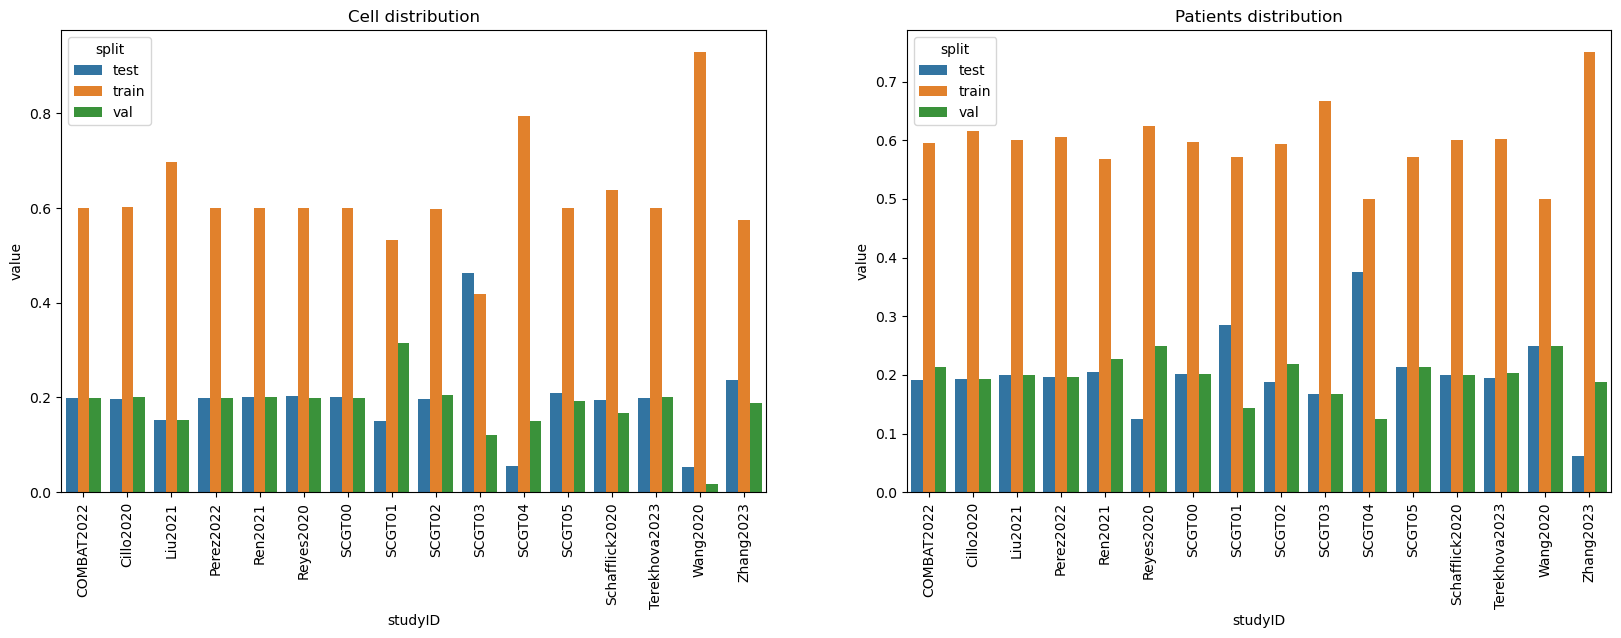

In [14]:
_, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(x=target_y, y='value', hue='split', data=cell_plot_data, ax=axs[0])
axs[0].set_title('Cell distribution')
axs[0].tick_params(axis='x', labelrotation=90)
sns.barplot(x=target_y, y='value', hue='split', data=pat_plot_data, ax=axs[1])
axs[1].set_title('Patients distribution')
axs[1].tick_params(axis='x', labelrotation=90)

os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/"), exist_ok=True)

plt.savefig(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/{RUN_NAME}{CELL_TYPE}_split_quality.pdf'), bbox_inches='tight', dpi=300)

In [15]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/"), exist_ok=True)

np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_train_idxs.npy"), train_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_val_idxs.npy"), val_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_test_idxs.npy"), test_idxs)

### SUBSET DATASET INTO TRAIN/TEST/VAL SPLITS

In [16]:
X_train = adata.X[train_idxs]
X_test = adata.X[test_idxs]
X_val = adata.X[val_idxs]
X_train.shape, X_test.shape, X_val.shape

((13927, 935), (4450, 935), (4525, 935))

In [17]:
y_train = adata.obs.iloc[train_idxs][target_y].values.astype(str)
y_test = adata.obs.iloc[test_idxs][target_y].values.astype(str)
y_val = adata.obs.iloc[val_idxs][target_y].values.astype(str)
y_train.shape, y_test.shape, y_val.shape 

((13927,), (4450,), (4525,))

In [18]:
lenc = LabelEncoder()
y_train_enc = lenc.fit_transform(y_train)
y_val_enc = lenc.transform(y_val)
y_test_enc = lenc.transform(y_test)

### GENERATE F1 

In [19]:
def custom_f1_score(y_true, y_pred):
    return -f1_score(y_true, y_pred.argmax(1), average='weighted')

In [20]:
eval_metric=custom_f1_score
eval_metric_name='custom_f1_score'

def objective(trial):
    params = {
        'sampling_method': 'gradient_based',
        'n_estimators': 1500,
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1, log=True),
    }
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-{eval_metric_name}')
    xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        early_stopping_rounds=20,
        callbacks=[pruning_callback],
        **params
    )
    xgb.fit(
        X_train, 
        y_train_enc, 
        verbose=0,
        eval_set=[(X_val, y_val_enc)],
    )
    trial.set_user_attr('best_iteration', xgb.best_iteration)

    return xgb.best_score

In [21]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
wandb_kwargs = {"project": "xgboost", "name": f"{RUN_NAME}{CELL_TYPE}"}
wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
study.optimize(objective, n_trials=N_TRIALS, callbacks=[wandbc], gc_after_trial=True)

[I 2025-03-17 18:03:54,969] A new study created in memory with name: no-name-2c6bb186-c45e-4f75-8e31-dab24d9b2a24


/tmp/ipykernel_1050228/350114600.py:4: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: dav1989 (inflammation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.19.8


wandb: Run data is saved locally in /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/wandb/run-20250317_180357-q4fln1da
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run studyID_pDC


wandb: ⭐️ View project at https://wandb.ai/inflammation/xgboost


wandb: 🚀 View run at https://wandb.ai/inflammation/xgboost/runs/q4fln1da


[I 2025-03-17 18:04:00,928] Trial 0 finished with value: -0.875108 and parameters: {'max_depth': 9, 'min_child_weight': 238, 'subsample': 0.7587945476302645, 'colsample_bynode': 0.6387926357773329, 'learning_rate': 0.0026368755339723046}. Best is trial 0 with value: -0.875108.


[I 2025-03-17 18:04:04,292] Trial 1 finished with value: -0.998996 and parameters: {'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8795585311974417, 'colsample_bynode': 0.6410035105688879, 'learning_rate': 0.08148293210105287}. Best is trial 1 with value: -0.998996.


[I 2025-03-17 18:04:07,036] Trial 2 finished with value: -0.879154 and parameters: {'max_depth': 3, 'min_child_weight': 243, 'subsample': 0.8491983767203796, 'colsample_bynode': 0.29110519961044856, 'learning_rate': 0.003095566460242371}. Best is trial 1 with value: -0.998996.


[I 2025-03-17 18:04:41,399] Trial 3 finished with value: -0.988506 and parameters: {'max_depth': 6, 'min_child_weight': 77, 'subsample': 0.5722807884690141, 'colsample_bynode': 0.48875051677790415, 'learning_rate': 0.006109683510122491}. Best is trial 1 with value: -0.998996.


[I 2025-03-17 18:05:04,018] Trial 4 finished with value: -0.99627 and parameters: {'max_depth': 14, 'min_child_weight': 35, 'subsample': 0.3629301836816964, 'colsample_bynode': 0.4297256589643226, 'learning_rate': 0.01701841881702917}. Best is trial 1 with value: -0.998996.


[I 2025-03-17 18:05:10,856] Trial 5 pruned. Trial was pruned at iteration 42.


[I 2025-03-17 18:05:15,390] Trial 6 finished with value: -0.994984 and parameters: {'max_depth': 13, 'min_child_weight': 43, 'subsample': 0.1585464336867516, 'colsample_bynode': 0.9539969835279999, 'learning_rate': 0.4038423798071558}. Best is trial 1 with value: -0.998996.


[I 2025-03-17 18:05:17,003] Trial 7 pruned. Trial was pruned at iteration 2.


[I 2025-03-17 18:05:18,008] Trial 8 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:05:18,845] Trial 9 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:05:33,514] Trial 10 finished with value: -0.998996 and parameters: {'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9725833997090791, 'colsample_bynode': 0.11616568805333755, 'learning_rate': 0.17780618353487967}. Best is trial 1 with value: -0.998996.


[I 2025-03-17 18:05:43,509] Trial 11 finished with value: -0.999216 and parameters: {'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.9818290990185045, 'colsample_bynode': 0.17702656156719, 'learning_rate': 0.11568531411766632}. Best is trial 11 with value: -0.999216.


[I 2025-03-17 18:05:59,269] Trial 12 finished with value: -0.999437 and parameters: {'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9762317723681219, 'colsample_bynode': 0.14667845540225039, 'learning_rate': 0.07220195396446882}. Best is trial 12 with value: -0.999437.


[I 2025-03-17 18:06:00,109] Trial 13 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:06:01,007] Trial 14 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:06:12,091] Trial 15 finished with value: -0.998992 and parameters: {'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.7300199336663715, 'colsample_bynode': 0.2687793682900305, 'learning_rate': 0.1602439470815397}. Best is trial 12 with value: -0.999437.


[I 2025-03-17 18:06:13,111] Trial 16 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:06:13,966] Trial 17 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:06:14,767] Trial 18 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:06:15,640] Trial 19 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:06:16,589] Trial 20 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:06:28,339] Trial 21 pruned. Trial was pruned at iteration 33.


[I 2025-03-17 18:06:29,348] Trial 22 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:06:37,541] Trial 23 pruned. Trial was pruned at iteration 33.


[I 2025-03-17 18:06:39,417] Trial 24 pruned. Trial was pruned at iteration 3.


[I 2025-03-17 18:06:40,292] Trial 25 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:06:41,119] Trial 26 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:06:42,059] Trial 27 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:06:54,879] Trial 28 finished with value: -0.999216 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.9966028459647209, 'colsample_bynode': 0.7547835364105744, 'learning_rate': 0.05867694766894226}. Best is trial 12 with value: -0.999437.


[I 2025-03-17 18:06:55,642] Trial 29 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:06:56,807] Trial 30 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:04,020] Trial 31 finished with value: -0.998811 and parameters: {'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.9238712829486063, 'colsample_bynode': 0.669409216514185, 'learning_rate': 0.07160553412692008}. Best is trial 12 with value: -0.999437.


[I 2025-03-17 18:07:05,122] Trial 32 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:06,142] Trial 33 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:13,249] Trial 34 pruned. Trial was pruned at iteration 26.


[I 2025-03-17 18:07:14,184] Trial 35 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:14,839] Trial 36 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:15,836] Trial 37 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:16,745] Trial 38 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:17,653] Trial 39 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:18,543] Trial 40 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:26,155] Trial 41 finished with value: -0.999216 and parameters: {'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9576719995752544, 'colsample_bynode': 0.14373131846370663, 'learning_rate': 0.206948468960093}. Best is trial 12 with value: -0.999437.


[I 2025-03-17 18:07:27,108] Trial 42 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:28,580] Trial 43 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:30,179] Trial 44 pruned. Trial was pruned at iteration 2.


[I 2025-03-17 18:07:30,892] Trial 45 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:31,927] Trial 46 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:32,823] Trial 47 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:33,594] Trial 48 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:35,214] Trial 49 pruned. Trial was pruned at iteration 2.


In [22]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/"), exist_ok=True)

joblib.dump(study, here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/{RUN_NAME}{CELL_TYPE}_xgboost.pkl'))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/study/studyID_pDC_xgboost.pkl']

In [23]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/"), exist_ok=True)

fig = optuna.visualization.plot_parallel_coordinate(study)
fig.write_image(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/{RUN_NAME}{CELL_TYPE}_pcoord.pdf'))

In [24]:
n_estimators = int(study.best_trial.user_attrs['best_iteration']*1.2)
xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        n_estimators=n_estimators,
        **study.best_trial.params
    )
xgb.fit(
    ssp.vstack((X_train, X_val)), 
    np.concatenate((y_train_enc, y_val_enc)), 
    eval_set=[(X_test, y_test_enc)],
    verbose=1,
)

[0]	validation_0-mlogloss:2.23856	validation_0-custom_f1_score:-0.95480


[1]	validation_0-mlogloss:1.92558	validation_0-custom_f1_score:-0.98079


[2]	validation_0-mlogloss:1.69984	validation_0-custom_f1_score:-0.98864


[3]	validation_0-mlogloss:1.52155	validation_0-custom_f1_score:-0.99159


[4]	validation_0-mlogloss:1.37392	validation_0-custom_f1_score:-0.99275


[5]	validation_0-mlogloss:1.24965	validation_0-custom_f1_score:-0.99368


[6]	validation_0-mlogloss:1.14280	validation_0-custom_f1_score:-0.99415


[7]	validation_0-mlogloss:1.04926	validation_0-custom_f1_score:-0.99415


[8]	validation_0-mlogloss:0.96593	validation_0-custom_f1_score:-0.99508


[9]	validation_0-mlogloss:0.89101	validation_0-custom_f1_score:-0.99598


[10]	validation_0-mlogloss:0.82413	validation_0-custom_f1_score:-0.99621


[11]	validation_0-mlogloss:0.76392	validation_0-custom_f1_score:-0.99693


[12]	validation_0-mlogloss:0.70909	validation_0-custom_f1_score:-0.99739


[13]	validation_0-mlogloss:0.65886	validation_0-custom_f1_score:-0.99739


[14]	validation_0-mlogloss:0.61193	validation_0-custom_f1_score:-0.99762


[15]	validation_0-mlogloss:0.56898	validation_0-custom_f1_score:-0.99785


[16]	validation_0-mlogloss:0.53040	validation_0-custom_f1_score:-0.99785


[17]	validation_0-mlogloss:0.49425	validation_0-custom_f1_score:-0.99762


[18]	validation_0-mlogloss:0.46074	validation_0-custom_f1_score:-0.99808


[19]	validation_0-mlogloss:0.42947	validation_0-custom_f1_score:-0.99785


[20]	validation_0-mlogloss:0.40096	validation_0-custom_f1_score:-0.99808


[21]	validation_0-mlogloss:0.37466	validation_0-custom_f1_score:-0.99808


[22]	validation_0-mlogloss:0.35089	validation_0-custom_f1_score:-0.99830


[23]	validation_0-mlogloss:0.32804	validation_0-custom_f1_score:-0.99853


[24]	validation_0-mlogloss:0.30640	validation_0-custom_f1_score:-0.99853


[25]	validation_0-mlogloss:0.28653	validation_0-custom_f1_score:-0.99853


[26]	validation_0-mlogloss:0.26809	validation_0-custom_f1_score:-0.99853


[27]	validation_0-mlogloss:0.25102	validation_0-custom_f1_score:-0.99830


[28]	validation_0-mlogloss:0.23487	validation_0-custom_f1_score:-0.99808


[29]	validation_0-mlogloss:0.22048	validation_0-custom_f1_score:-0.99808


[30]	validation_0-mlogloss:0.20697	validation_0-custom_f1_score:-0.99808


[31]	validation_0-mlogloss:0.19409	validation_0-custom_f1_score:-0.99830


[32]	validation_0-mlogloss:0.18214	validation_0-custom_f1_score:-0.99830


[33]	validation_0-mlogloss:0.17084	validation_0-custom_f1_score:-0.99830


[34]	validation_0-mlogloss:0.16011	validation_0-custom_f1_score:-0.99808


[35]	validation_0-mlogloss:0.15042	validation_0-custom_f1_score:-0.99830


[36]	validation_0-mlogloss:0.14150	validation_0-custom_f1_score:-0.99830


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.14667845540225039,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function custom_f1_score at 0x7b4950ceefc0>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.07220195396446882, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=37, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [25]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/"), exist_ok=True)

joblib.dump(xgb, (here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/{RUN_NAME}{CELL_TYPE}_xgb.json')))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/best_model/studyID_pDC_xgb.json']

In [26]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/"), exist_ok=True)

(pd.DataFrame(np.array((y_test, y_test_enc, xgb.predict(X_test))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_test.zip')))
(pd.DataFrame(np.array((y_train, y_train_enc, xgb.predict(X_train))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_train.zip')))

/scratch_isilon/groups/singlecell/shared/conda_env/xgboostGPU/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning:

[18:07:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.


